In [271]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix

<h2>Loading training data</h2>

In [288]:
data = pd.read_csv("D:\\Junk\\ml\\all\\training_variantsX\\training_variants")
print(data.shape)
data.head()

(3321, 4)


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [289]:
data.Gene.value_counts()[:10]

BRCA1     264
TP53      163
EGFR      141
PTEN      126
BRCA2     125
KIT        99
BRAF       93
ERBB2      69
ALK        69
PDGFRA     60
Name: Gene, dtype: int64

In [290]:
data.Variation = data.Variation.str.replace('\s+', '_')

In [297]:
data_text = pd.read_csv("D:\\Junk\\ml\\all\\training_textX\\training_text", 
                        sep = "\|\|",
                        engine="python", 
                        names = ["ID", "Text"], 
                        skiprows=1)

In [298]:
data_text.head()

,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [307]:
#text preprocessing
import sys
import unicodedata
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize

punctuation = dict.fromkeys(i for i in range(sys.maxunicode) if unicodedata.category(chr(i))[0] == 'P')
stopwords = stopwords.words('english')
porter = PorterStemmer()

def nlp_preprocessing(text_data):
    token = [string.strip() for string in word_tokenize(text_data) if string not in stopwords]
    no_punct = [string.translate(punctuation) for string in token]
    tolower     = [string.lower() for string in no_punct]
    return ' '.join([string for string in tolower])

In [308]:
%%time
data_text["Text"] = data_text["Text"].apply(nlp_preprocessing)

Wall time: 7min 52s


In [309]:
data_text.head()

,ID,Text
0,0,cyclindependent kinases cdks regulate variet...
1,1,abstract background nonsmall cell lung cancer ...
2,2,abstract background nonsmall cell lung cancer ...
3,3,recent evidence demonstrated acquired uniparen...
4,4,oncogenic mutations monomeric casitas blineage...


<p>Check the relevance of features for prediction</p>

In [310]:
from scipy.stats import chi2_contingency

In [311]:
t=pd.crosstab(data.Gene, data.Class)
_,pval,_,_ = chi2_contingency(t)
if(pval < 0.05):
    print("Feature 'Gene' is relevant for classification")
else:
    print("Feature 'Gene' is not relevant for classification")

Feature 'Gene' is relevant for classification


In [312]:
t=pd.crosstab(data.Variation, data.Class)
_,pval,_,_ = chi2_contingency(t)
if(pval < 0.05):
    print("Feature 'Variation' is relevant for classification")
else:
    print("Feature 'Variation' is not relevant for classification")

Feature 'Variation' is relevant for classification


In [313]:
result = pd.merge(data, data_text, on = 'ID', how = "left")
result.head()

,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating_Mutations,1,cyclindependent kinases cdks regulate variet...
1,1,CBL,W802*,2,abstract background nonsmall cell lung cancer ...
2,2,CBL,Q249E,2,abstract background nonsmall cell lung cancer ...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas blineage...


<h6>Feature engineering</h6> 
<p>convert categories to one hot encoding</p>

In [314]:
from sklearn.preprocessing import LabelBinarizer

In [315]:
one_hot_g = LabelBinarizer() #Gene vectorizer
one_hot_v = LabelBinarizer() #variation vectorizer

gene_one_hot = one_hot_g.fit_transform(result.Gene)
variation_one_hot = one_hot_v.fit_transform(result.Variation)

<p>check relevance of new features for classification</p>

In [362]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score, cross_val_predict

In [326]:
%%time
scores = cross_val_score(LogisticRegressionCV(n_jobs=-1), gene_one_hot, result.Class)

Wall time: 16.8 s


In [327]:
print(str(np.mean(scores)) + ' +/- ' + str(np.std(scores)))

0.261408325014 +/- 0.0246923507611


In [328]:
%%time
scores_v = cross_val_score(LogisticRegressionCV(n_jobs=-1), variation_one_hot, result.Class)

Wall time: 1min 12s


In [329]:
print(str(np.mean(scores_v)) + ' +/- ' + str(np.std(scores_v)))

0.338774388456 +/- 0.00788815796729


In [146]:
#convert text to vectors using tf-idf

In [321]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [322]:
vectorizer = TfidfVectorizer(max_features=1000)

In [323]:
%%time
text2tfidf = vectorizer.fit_transform(result.Text)

Wall time: 24.5 s


In [330]:
%%time
scores_tfidf = cross_val_score(LogisticRegressionCV(n_jobs=-1), text2tfidf, result.Class)

Wall time: 52 s


In [331]:
print(str(np.mean(scores_tfidf)) + ' +/- ' + str(np.std(scores_tfidf)))

0.304232903356 +/- 0.0362541565943


In [158]:
#Stack features

In [332]:
features = np.hstack((np.hstack((gene_one_hot, variation_one_hot)), text2tfidf.toarray()))
target = np.array(list(result.Class))
features.shape

(3321, 4260)

<h6>Benchmarking using 'a Random model'</h6>

In [333]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split

In [334]:
features_train, features_test, target_train, target_test = train_test_split(features, target, stratify=target, test_size=0.2)

In [335]:
dummy = DummyClassifier(strategy="uniform", random_state = 1)
dummy.fit(features_train, target_train)
probas = dummy.predict_proba(features_test)

print('Log loss: {}'.format(log_loss(target_test, probas)))

Log loss: 2.1972245773362196


<h6>Machine learning models</h6>
<p>Selecting best model from multiple algorithms</p>

In [336]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [349]:
pipe = Pipeline([("classifier", MultinomialNB())])

param_grid  = [
                {"classifier": [MultinomialNB()], "classifier__alpha": [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]}, 
                {"classifier": [LinearSVC(class_weight='balanced')], "classifier__C":[10 ** x for x in range(-5, 3)]},
                {"classifier": [KNeighborsClassifier()], "classifier__n_neighbors":[5, 11, 15, 21, 31, 41, 51, 99]},
                {"classifier": [LogisticRegression(class_weight='balanced')], "classifier__class_weight": [None, "balanced"], "classifier__C": [10 ** x for x in range(-6, 3)]},
                {"classifier": [RandomForestClassifier()], "classifier__n_estimators": [10,50,100,200,500,1000], "classifier__max_depth":[2,3,5,10]}
               ]

gridsearch = GridSearchCV(pipe, param_grid, n_jobs = -1)

In [350]:
%%time
best_model = gridsearch.fit(features_train, target_train)

Wall time: 6min 49s


<h7>The best learning model is: </h7>

In [351]:
best_model.best_estimator_.get_params()["classifier"]

LogisticRegression(C=10, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [343]:
#Evaluate the best model

In [352]:
probas = best_model.predict_proba(features_test)

In [353]:
class_names = np.unique(result.Class)
y_hat = class_names[np.argmax(probas, axis=1)]
print('Log loss: {}'.format(log_loss(target_test, probas)))
print('Accuracy: {}'.format(accuracy_score(target_test, y_hat)))

Log loss: 0.9513379743484376
Accuracy: 0.6526315789473685


<h5>Log-loss of best model is : 0.95</h5>

In [ ]:
#plot heatmap

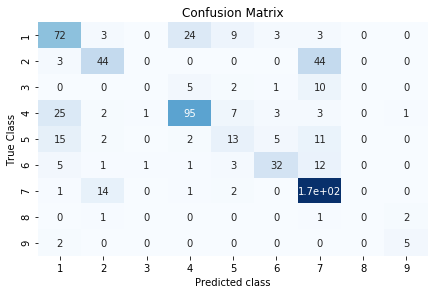

In [354]:
matrix = confusion_matrix(target_test, y_hat)
cm = pd.DataFrame(matrix, index = class_names, columns = class_names)

sns.heatmap(cm, annot=True, cbar=None, cmap="Blues")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.ylabel("True Class")
plt.xlabel("Predicted class")
plt.show()

In [ ]:
#analyze learning curve

In [345]:
from sklearn.model_selection import learning_curve
from sklearn.base import clone

In [355]:
%%time
train_sizes, train_scores, test_scores = learning_curve(best_model.best_estimator_.get_params()["classifier"], features, target, cv=5, 
                                                        n_jobs=-1, scoring="accuracy", train_sizes=np.linspace(.05, 1.0, 50))

train_mean = np.mean(train_scores, axis=1)
train_std  = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std  = np.std(test_scores, axis=1)

Wall time: 4min 35s


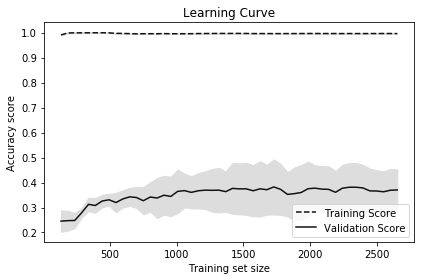

In [358]:
plt.plot(train_sizes, train_mean, '--', color = '#111111', label = "Training Score")
plt.plot(train_sizes, test_mean, color = '#111111', label = "Validation Score")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color = "#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color = "#DDDDDD")

plt.title("Learning Curve")
plt.xlabel("Training set size")
plt.ylabel("Accuracy score")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [357]:
#stacking classifiers

In [359]:
from mlxtend.classifier import StackingClassifier

In [368]:
clf1 = LogisticRegression(C=0.001, class_weight='balanced')
clf2 = LinearSVC(C = 1, class_weight='balanced')
clf3 = MultinomialNB(alpha=0.001)
lr   = LogisticRegression()


sclf = StackingClassifier(classifiers=[clf1, clf2, clf3], 
                          meta_classifier=lr)

params = {'meta-logisticregression__C': [0.0001,0.001,0.01,0.1,1,10]}

grid = GridSearchCV(estimator=sclf, 
                    param_grid=params, 
                    cv=5,
                    refit=True)


In [364]:
from sklearn.model_selection import StratifiedKFold

In [365]:
%%time
probas = cross_val_predict(grid, features, target, cv=StratifiedKFold(random_state=1), 
                              n_jobs=-1, method='predict_proba', verbose=0)

In [367]:
y_hat = class_names[np.argmax(probas, axis=1)]
print('Log loss: {}'.format(log_loss(target, probas)))
print('Accuracy: {}'.format(accuracy_score(target, y_hat)))

Log loss: 3.914589453019502
Accuracy: 0.3152664859981933
